# Lactate Dehydrogenase Assay Analysis Notebook

This notebook analyzes raw data from the lactate dehydrogenase (LDH) assay. This enzyme activity assay measures LDH levels in cell culture supernatant. LDH is a constitutively expressed cytosolic enzyme necessary for anaerobic respiration. It performs reversible conversion of lactate to pyruvate, resulting in the production of one equivalent of NADH, the molecule detected by this assay. Typically, LDH is only released into the culture supernatant during loss of cell membrane integrity (i.e., due to cell death).

### Inputs
The input data for this notebook are a raw data file (`data_filename`) from a plate reader and a sample manifest (`manifest_filename`), which is filled out by the experimenter for each experiment. Other parameters defined by the user include: the names of the assay controls (`standard_columns` and `background`) from the sample manifest; the total sample volume in each well (`V`); and the name of the experiment (`experiment_id`), which is used for plot labels. After initial processing of the raw data, the user can select two time points (`t1` and `t2`) in the linear response range that are used to determine the LDH enzyme level in each analyte sample.

Due to the limited dynamic range of absorbance assays, it often makes sense to test multiple dilutions of an analyte of unknown LDH concentration. To deal with this, the notebook parses the dilution factors when calculating LDH concentration. For samples with multiple dilutions, it will also select the dilution factor most likely to produce an accurate LDH concentration (based on the NADH concentrations used for the standard curve). We performed 1x and/or 5x dilutions of all standards. In order for this code block to properly parse and filter samples, each sample name in the manifest should take the form 'sample_name, 1x dilution' or 'sample_name, 5x dilution'.

### Outputs
The notebook parses the input data file into metadata and well-by-well time-series data and uses the sample manifest to generate labeled and background-subtracted data, which are saved as csvs. For each time point, standard curve plots are generated and saved as png files. For each analyte sample, the notebook plots absorbance values over time and saves these as png files. Next, the notebook performs quadratic curve fits to the standard curves at each user-defined time point and uses these to determine NADH levels at each time point and LDH levels for each analyte. These results are exported as a csv.

The notebook will then filter the results so that the most accurate dilution is selected to plot. A data file with these filtered results and a simplified LDH concentration plot are exported as a csv and png, respectively.

Finally, the notebook performs statistical analysis and generates one-way ANOVA results and Tukey HSD comparisons. The latter is saved as a csv file.

In [1]:
import os
import re
from collections import defaultdict

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns

In [2]:
# Parameterization

data_filename = "../data_files/20250211_ldh_assay.csv"  # enter raw data file name here
manifest_filename = (
    "../data_files/20250211_ldh_manifest.csv"  # enter sample manifest file name here
)

background = "0"  # enter the data label for the background samples
standard_columns = [
    "250",
    "200",
    "150",
    "100",
    "50",
]  # enter the standard column values as a list of strings

V = 0.05  # Total sample volume in mL, should be 0.05 unless the protocol is altered
experiment_id = "20250211 Panel of Pruritogens in RBL-2H3"  # For final data plot label

In [3]:
if os.path.exists(data_filename):
    data = pd.read_csv(data_filename)
    print(f"File '{data_filename}' loaded successfully.")
else:
    print(f"Error: File '{data_filename}' not found at the specified location.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

File '../data_files/20250211_ldh_assay.csv' loaded successfully.


In [4]:
# Metadata are found in rows where both column A and column B have non-empty values,
# so metadata are extracted by identifying rows with non-empty values in these columns.

output_directory = os.path.splitext(os.path.basename(data_filename))[0]
output_path = "../output_files/" + output_directory
os.makedirs(output_path, exist_ok=True)

output_filename = output_path + "/" + output_directory

metadata = data.dropna(subset=["User", "Public"])
metadata = metadata.iloc[:, :2]
metadata.to_csv(output_filename + "_metadata.csv", index=False)
metadata

,User,Public
0,Protocol name,New ABS Protocol
1,Time of export,02/11/2025 22:34:26
2,Time of last change,02/11/2025 21:58:29
3,Time of last use (end time),02/11/2025 22:29:11
4,Software version,1.2.0.0
5,Instrument name,iD3-2585
6,Serial number,2585
10,Experiment name,Experiment 1
13,Plate name,Plate 1
15,Microplate name,Standard clrbtm


In [5]:
# Samples are laid out in columns defined by the well position in a 96-well plate,
# each row corresponds to a time-point.
# Look for a row where columns contain values A1, A2, ..., H11, H12.

pattern = r"^[A-H][1-9]$|^[A-H]1[0-2]$"


def find_header_index(data, pattern):
    """
    Find the row index of the defined pattern of well labels that
    identifies the location of the sample data.

    Args:
        data: The raw dataframe exported from the plate reader and imported into pandas
        pattern: The regular expression that defines the well headers (typically A1 - H12)

    Returns:
        int: The row index of the well headers
    """
    for idx, row in data.iterrows():
        non_nan_values = row[2:].dropna()
        if (
            len(non_nan_values) > 0
            and sum(bool(re.match(pattern, str(val))) for val in non_nan_values)
            >= len(non_nan_values) / 2
        ):
            return idx
    raise ValueError("No valid header row found. Please check the data structure.")


# Header row index should be found by find_header_index.
# The header_index printout can be used to verify that this is done correctly.
# Check that the raw csv file is appropriately structured if issues are encountered.
header_index = find_header_index(data, pattern)
print(header_index)

sample_data = data.iloc[header_index + 1 :, 2:].dropna(how="all")
sample_data = sample_data.reset_index(drop=True)

# The first column is 'Cycle (seconds)', defining it as the time column,
# and remaining columns are well positions (A1 - H12).
column_names = ["Cycle (seconds)"] + [
    col for col in data.iloc[header_index, 2:] if re.match(pattern, str(col))
]
sample_data.columns = column_names

sample_data.to_csv(output_filename + "_sample_data.csv", index=False)
sample_data

50


,Cycle (seconds),A1,A2,A3,A4,A5,A6,A7,A8,A9,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0,0.116,0.528,0.599,0.51,0.477,0.48,0.536,0.45,0.476,...,0.642,0.446,0.247,0.049,0.033,0.033,0.033,0.033,NaN,NaN
1,119.04,0.118,0.668,0.78,0.67,0.622,0.638,0.687,0.586,0.623,...,0.64,0.446,0.246,0.049,0.033,0.033,0.033,0.033,NaN,NaN
2,239.21,0.118,0.81,0.962,0.83,0.767,0.792,0.798,0.724,0.768,...,0.638,0.445,0.246,0.05,0.033,0.033,0.033,0.033,NaN,NaN
3,360.12,0.119,0.951,1.141,0.988,0.91,0.941,0.895,0.859,0.91,...,0.636,0.445,0.245,0.05,0.033,0.033,0.033,0.033,NaN,NaN
4,480.05,0.119,1.086,1.315,1.14,1.05,1.083,0.987,0.989,1.046,...,0.636,0.444,0.244,0.05,0.033,0.033,0.033,0.033,NaN,NaN
5,599.94,0.119,1.216,1.483,1.286,1.185,1.222,1.076,1.116,1.179,...,0.636,0.444,0.244,0.05,0.033,0.033,0.033,0.033,NaN,NaN
6,720,0.12,1.343,1.645,1.428,1.318,1.356,1.162,1.239,1.308,...,0.635,0.443,0.244,0.05,0.033,0.033,0.033,0.033,NaN,NaN
7,840.06,0.12,1.466,1.801,1.566,1.447,1.488,1.248,1.359,1.434,...,0.634,0.443,0.244,0.05,0.033,0.033,0.033,0.033,NaN,NaN
8,959.97,0.12,1.586,1.953,1.7,1.572,1.615,1.337,1.476,1.557,...,0.634,0.442,0.244,0.051,0.033,0.033,0.033,0.033,NaN,NaN
9,1080.11,0.12,1.703,2.1,1.831,1.694,1.738,1.425,1.591,1.677,...,0.634,0.442,0.243,0.05,0.033,0.033,0.033,0.033,NaN,NaN


In [6]:
# Data must be restructured and labeled for plotting and analysis,
# so sample manifest is used to sort and label data.

if os.path.exists(manifest_filename):
    manifest = pd.read_csv(manifest_filename)
    print(f"File '{manifest_filename}' loaded successfully.")
else:
    print(f"Error: File '{manifest_filename}' not found at the specified location.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

manifest

File '../data_files/20250211_ldh_manifest.csv' loaded successfully.


,Manifest,1,2,3,4,5,6,7,8,9,10,11,12
0,A,NaN,"5-HT , 1x dilution","SLIGRL , 1x dilution","HA , 1x dilution","Cq , 1x dilution","ß-Ala , 1x dilution","PAMP12 , 1x dilution","Subs. P , 1x dilution","PBS, 1x dilution","LDH pos CN, 1x dilution",NaN,NaN
1,B,NaN,"5-HT , 1x dilution","SLIGRL , 1x dilution","HA , 1x dilution","Cq , 1x dilution","ß-Ala , 1x dilution","PAMP12 , 1x dilution","Subs. P , 1x dilution","PBS, 1x dilution","LDH pos CN, 1x dilution",NaN,NaN
2,C,NaN,"5-HT , 1x dilution","SLIGRL , 1x dilution","HA , 1x dilution","Cq , 1x dilution","ß-Ala , 1x dilution","PAMP12 , 1x dilution","Subs. P , 1x dilution","PBS, 1x dilution","LDH pos CN, 1x dilution",NaN,NaN
3,D,"48/80 , 5x dilution","5-HT , 5x dilution","SLIGRL , 5x dilution","HA , 5x dilution","Cq , 5x dilution","ß-Ala , 5x dilution","PAMP12 , 5x dilution","Subs. P , 5x dilution",NaN,"LDH pos CN, 5x dilution",NaN,NaN
4,E,"48/80 , 5x dilution","5-HT , 5x dilution","SLIGRL , 5x dilution","HA , 5x dilution","Cq , 5x dilution","ß-Ala , 5x dilution","PAMP12 , 5x dilution","Subs. P , 5x dilution",NaN,"LDH pos CN, 5x dilution",NaN,NaN
5,F,"48/80 , 5x dilution","5-HT , 5x dilution","SLIGRL , 5x dilution","HA , 5x dilution","Cq , 5x dilution","ß-Ala , 5x dilution","PAMP12 , 5x dilution","Subs. P , 5x dilution",NaN,"LDH pos CN, 5x dilution",NaN,NaN
6,G,250,200,150,100,50,0,NaN,NaN,NaN,NaN,NaN,NaN
7,H,250,200,150,100,50,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# A dictionary relating each well position to the corresponding sample name
# will be used to label the raw data.
manifest_dict = {}

for _index, row in manifest.iterrows():
    row_label = row["Manifest"]
    for col_label, value in row.items():
        if col_label != "Manifest" and pd.notna(value):
            well_position = f"{row_label}{col_label}"
            manifest_dict[well_position] = value

# Retain only columns that exist in the manifest_dict keys or are 'Cycle (seconds)'
columns_to_keep = [
    col for col in sample_data.columns if col in manifest_dict or col == "Cycle (seconds)"
]
sample_data_labeled = sample_data[columns_to_keep]

# Rename columns based on the manifest_dict values
sample_data_labeled = sample_data_labeled.rename(columns=manifest_dict)

# Clean-up steps are included to make sure that elements in
# sample_data_labeled are of appropriate types.
# All cell values are floats or NaN, all column header values are strings.
sample_data_labeled = sample_data_labeled.replace("#SAT", np.nan)
sample_data_labeled.columns = sample_data_labeled.columns.map(
    lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x)
)

sample_data_labeled.to_csv(output_filename + "_sample_data_labeled.csv", index=False)
sample_data_labeled

,Cycle (seconds),"5-HT , 1x dilution","SLIGRL , 1x dilution","HA , 1x dilution","Cq , 1x dilution","ß-Ala , 1x dilution","PAMP12 , 1x dilution","Subs. P , 1x dilution","PBS, 1x dilution","LDH pos CN, 1x dilution",...,150,100,50,0,250,200,150,100,50,0
0,0,0.528,0.599,0.51,0.477,0.48,0.536,0.45,0.476,0.116,...,0.644,0.444,0.249,0.051,1.023,0.841,0.642,0.446,0.247,0.049
1,119.04,0.668,0.78,0.67,0.622,0.638,0.687,0.586,0.623,0.14,...,0.642,0.443,0.248,0.051,1.02,0.837,0.64,0.446,0.246,0.049
2,239.21,0.81,0.962,0.83,0.767,0.792,0.798,0.724,0.768,0.166,...,0.642,0.442,0.247,0.051,1.018,0.834,0.638,0.445,0.246,0.05
3,360.12,0.951,1.141,0.988,0.91,0.941,0.895,0.859,0.91,0.191,...,0.641,0.441,0.247,0.051,1.017,0.833,0.636,0.445,0.245,0.05
4,480.05,1.086,1.315,1.14,1.05,1.083,0.987,0.989,1.046,0.217,...,0.64,0.441,0.246,0.051,1.015,0.832,0.636,0.444,0.244,0.05
5,599.94,1.216,1.483,1.286,1.185,1.222,1.076,1.116,1.179,0.243,...,0.64,0.441,0.246,0.051,1.014,0.832,0.636,0.444,0.244,0.05
6,720,1.343,1.645,1.428,1.318,1.356,1.162,1.239,1.308,0.269,...,0.638,0.44,0.246,0.051,1.013,0.831,0.635,0.443,0.244,0.05
7,840.06,1.466,1.801,1.566,1.447,1.488,1.248,1.359,1.434,0.295,...,0.639,0.44,0.246,0.051,1.012,0.831,0.634,0.443,0.244,0.05
8,959.97,1.586,1.953,1.7,1.572,1.615,1.337,1.476,1.557,0.321,...,0.638,0.44,0.246,0.052,1.012,0.83,0.634,0.442,0.244,0.051
9,1080.11,1.703,2.1,1.831,1.694,1.738,1.425,1.591,1.677,0.347,...,0.638,0.439,0.246,0.052,1.012,0.83,0.634,0.442,0.243,0.05


In [8]:
# Background signal should be subtracted from all samples.
# Background signal is calculated separately at each time point
# to control for any time-dependent changes in the background signal.
# Check the blank_means printout to see whether the background signal
# changes significantly over time.


def generate_row_means(df):
    """
    Calculate the mean of each row in a dataframe.

    Args:
        df: A pandas dataframe.

    Returns:
        list[float]: A list of mean values of each row in the input dataframe.
    """
    df = df.apply(pd.to_numeric, errors="coerce")

    means = []

    for _, row in df.iterrows():
        row_mean = row.mean(skipna=True)
        means.append(float(row_mean))

    return means


filtered_data = sample_data_labeled[background]
filtered_data = filtered_data.apply(pd.to_numeric, errors="coerce")

blank_means = generate_row_means(filtered_data)
print(blank_means)

[0.05, 0.05, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0515, 0.051000000000000004, 0.0515, 0.0515, 0.0515, 0.0515, 0.052, 0.052]


In [9]:
def subtract_row_means(data, means):
    """
    Subtracts each value in a list of background means
    from the corresponding time row in the DataFrame.

    Args:
        data: A pandas dataframe containing labeled raw data.
        means: A list of floats containing the mean background signal at each time point.

    Returns:
        pd.Dataframe: Labeled background-subtracted data, with background columns dropped.
    """
    data_numeric = data.apply(pd.to_numeric, errors="coerce")

    if len(data_numeric) != len(means):
        raise ValueError("Length of means list must match the number of rows in the DataFrame.")

    data_subtracted = data_numeric.apply(lambda row: row - means[row.name], axis=1)

    return data_subtracted


sample_data_labeled_nb = subtract_row_means(sample_data_labeled, blank_means)
sample_data_labeled_nb = sample_data_labeled_nb.drop(columns=background)
sample_data_labeled_nb.to_csv(output_filename + "_sample_data_labeled_nb.csv", index=False)
sample_data_labeled_nb

,Cycle (seconds),"5-HT , 1x dilution","SLIGRL , 1x dilution","HA , 1x dilution","Cq , 1x dilution","ß-Ala , 1x dilution","PAMP12 , 1x dilution","Subs. P , 1x dilution","PBS, 1x dilution","LDH pos CN, 1x dilution",...,250,200,150,100,50,250,200,150,100,50
0,-0.0500,0.4780,0.5490,0.4600,0.4270,0.4300,0.4860,0.4000,0.4260,0.0660,...,0.9690,0.7880,0.5940,0.3940,0.1990,0.9730,0.7910,0.5920,0.3960,0.1970
1,118.9900,0.6180,0.7300,0.6200,0.5720,0.5880,0.6370,0.5360,0.5730,0.0900,...,0.9750,0.7850,0.5920,0.3930,0.1980,0.9700,0.7870,0.5900,0.3960,0.1960
2,239.1595,0.7595,0.9115,0.7795,0.7165,0.7415,0.7475,0.6735,0.7175,0.1155,...,0.9655,0.7825,0.5915,0.3915,0.1965,0.9675,0.7835,0.5875,0.3945,0.1955
3,360.0695,0.9005,1.0905,0.9375,0.8595,0.8905,0.8445,0.8085,0.8595,0.1405,...,0.9655,0.7835,0.5905,0.3905,0.1965,0.9665,0.7825,0.5855,0.3945,0.1945
4,479.9995,1.0355,1.2645,1.0895,0.9995,1.0325,0.9365,0.9385,0.9955,0.1665,...,0.9685,0.7815,0.5895,0.3905,0.1955,0.9645,0.7815,0.5855,0.3935,0.1935
5,599.8895,1.1655,1.4325,1.2355,1.1345,1.1715,1.0255,1.0655,1.1285,0.1925,...,0.9655,0.7815,0.5895,0.3905,0.1955,0.9635,0.7815,0.5855,0.3935,0.1935
6,719.9495,1.2925,1.5945,1.3775,1.2675,1.3055,1.1115,1.1885,1.2575,0.2185,...,0.9655,0.7795,0.5875,0.3895,0.1955,0.9625,0.7805,0.5845,0.3925,0.1935
7,840.0095,1.4155,1.7505,1.5155,1.3965,1.4375,1.1975,1.3085,1.3835,0.2445,...,0.9645,0.7795,0.5885,0.3895,0.1955,0.9615,0.7805,0.5835,0.3925,0.1935
8,959.9185,1.5345,1.9015,1.6485,1.5205,1.5635,1.2855,1.4245,1.5055,0.2695,...,0.9625,0.7775,0.5865,0.3885,0.1945,0.9605,0.7785,0.5825,0.3905,0.1925
9,1080.0590,1.6520,2.0490,1.7800,1.6430,1.6870,1.3740,1.5400,1.6260,0.2960,...,0.9610,0.7770,0.5870,0.3880,0.1950,0.9610,0.7790,0.5830,0.3910,0.1920


In [10]:
# Technical replicates should be collapsed into single columns to facilitate plotting.
# Each column will have a unique sample name. Technical replicates will be plotted in different rows
# that have the same time value in the time column.

unique_columns = list(dict.fromkeys(sample_data_labeled_nb.columns))

sample_data_collapsed = pd.DataFrame(columns=unique_columns)


def populate_collapsed_df(old_df, new_df):
    """
    Populates a new collapsed dataframe with values the well-by-well dataframe.

    Each treatment group in the collapsed dataframe is represented as a single
    column. Technical replicate values in these columns have the same time value
    in the time column.

    Arguments:
        old_df: The original DataFrame with labeled samples and timepoints.
        new_df:
            The collapsed DataFrame, with each unique sample as a column header,
            to be populated.

    Returns:
        pd.Dataframe:
            The collapsed dataframe, populated with absorbance values from old_df.
    """
    for _index, row in old_df.iterrows():
        cycle_time = row.iloc[old_df.columns.get_loc("Cycle (seconds)")]

        for col_idx in range(len(old_df.columns)):
            col_name = old_df.columns[col_idx]

            if col_name == "Cycle (seconds)":
                continue

            value = row.iloc[col_idx]
            if pd.isna(value):
                continue

            available_row_idx = new_df[
                (new_df["Cycle (seconds)"] == cycle_time) & pd.isna(new_df[col_name])
            ].index.min()

            if not pd.isna(available_row_idx):
                new_df.at[available_row_idx, col_name] = value
            else:
                new_row = {col_name: np.nan for col_name in new_df.columns}
                new_row["Cycle (seconds)"] = cycle_time
                new_row[col_name] = value
                new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)

    new_df.fillna(np.nan, inplace=True)

    return new_df


sample_data_collapsed = populate_collapsed_df(sample_data_labeled_nb, sample_data_collapsed)
sample_data_collapsed.to_csv(output_filename + "_collapsed.csv", index=False)
sample_data_collapsed

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_40782/1294355473.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)


,Cycle (seconds),"5-HT , 1x dilution","SLIGRL , 1x dilution","HA , 1x dilution","Cq , 1x dilution","ß-Ala , 1x dilution","PAMP12 , 1x dilution","Subs. P , 1x dilution","PBS, 1x dilution","LDH pos CN, 1x dilution",...,"Cq , 5x dilution","ß-Ala , 5x dilution","PAMP12 , 5x dilution","Subs. P , 5x dilution","LDH pos CN, 5x dilution",250,200,150,100,50
0,-0.0500,0.4780,0.5490,0.4600,0.4270,0.4300,0.4860,0.4000,0.4260,0.0660,...,0.0650,0.0620,0.0860,0.0580,0.0080,0.9690,0.7880,0.5940,0.3940,0.1990
1,-0.0500,0.4030,0.5030,0.4080,0.4150,0.4100,0.4160,0.3670,0.3840,0.0670,...,0.0600,0.0550,0.0780,0.0540,0.0100,0.9730,0.7910,0.5920,0.3960,0.1970
2,-0.0500,0.3900,0.4720,0.4110,0.3950,0.4010,0.4460,0.3530,0.3830,0.0640,...,0.0520,0.0510,0.0690,0.0500,0.0110,NaN,NaN,NaN,NaN,NaN
3,118.9900,0.6180,0.7300,0.6200,0.5720,0.5880,0.6370,0.5360,0.5730,0.0900,...,0.0940,0.0880,0.1200,0.0810,0.0130,0.9750,0.7850,0.5920,0.3930,0.1980
4,118.9900,0.5520,0.6790,0.5590,0.5650,0.5610,0.5440,0.5050,0.5230,0.0950,...,0.0890,0.0830,0.1150,0.0800,0.0140,0.9700,0.7870,0.5900,0.3960,0.1960
5,118.9900,0.5370,0.6530,0.5690,0.5490,0.5550,0.5920,0.4900,0.5270,0.0900,...,0.0810,0.0770,0.1050,0.0760,0.0170,NaN,NaN,NaN,NaN,NaN
6,239.1595,0.7595,0.9115,0.7795,0.7165,0.7415,0.7475,0.6735,0.7175,0.1155,...,0.1215,0.1155,0.1565,0.1055,0.0175,0.9655,0.7825,0.5915,0.3915,0.1965
7,239.1595,0.7015,0.8565,0.7105,0.7155,0.7105,0.6455,0.6405,0.6635,0.1225,...,0.1175,0.1085,0.1525,0.1055,0.0175,0.9675,0.7835,0.5875,0.3945,0.1955
8,239.1595,0.6855,0.8295,0.7265,0.6995,0.7075,0.7015,0.6245,0.6705,0.1175,...,0.1095,0.1035,0.1445,0.1025,0.0225,NaN,NaN,NaN,NaN,NaN
9,360.0695,0.9005,1.0905,0.9375,0.8595,0.8905,0.8445,0.8085,0.8595,0.1405,...,0.1495,0.1425,0.1935,0.1285,0.0235,0.9655,0.7835,0.5905,0.3905,0.1965


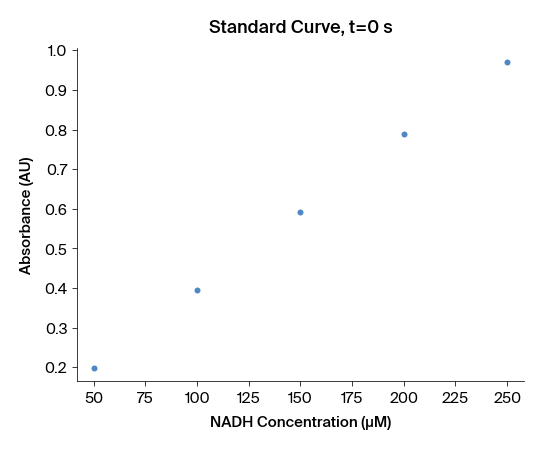

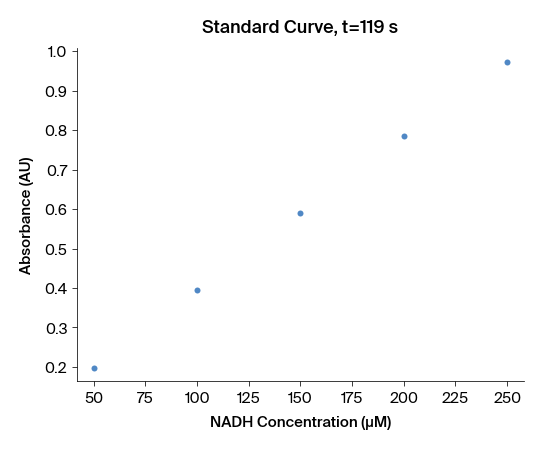

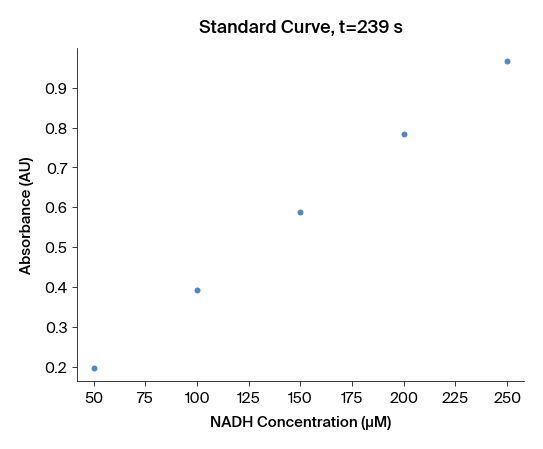

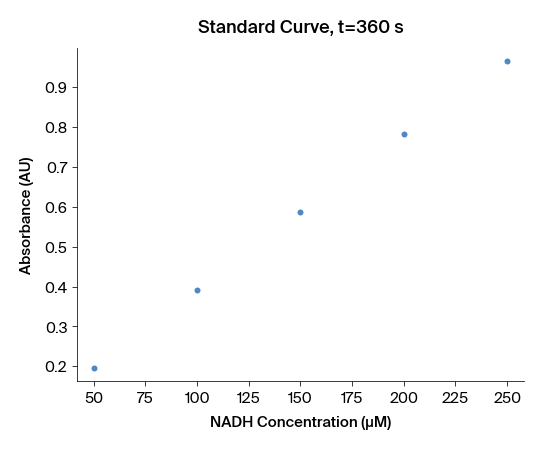

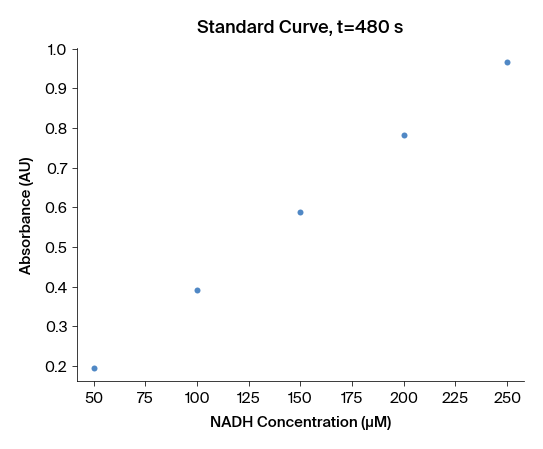

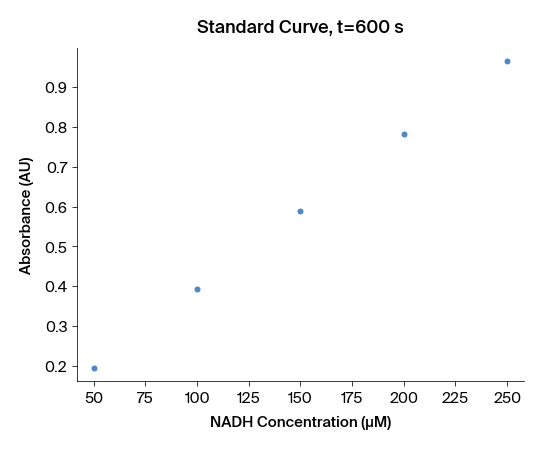

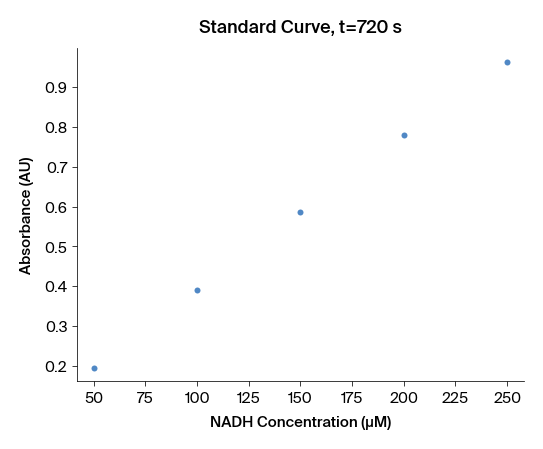

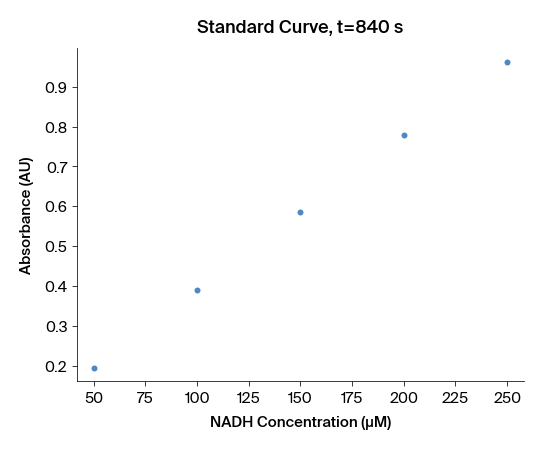

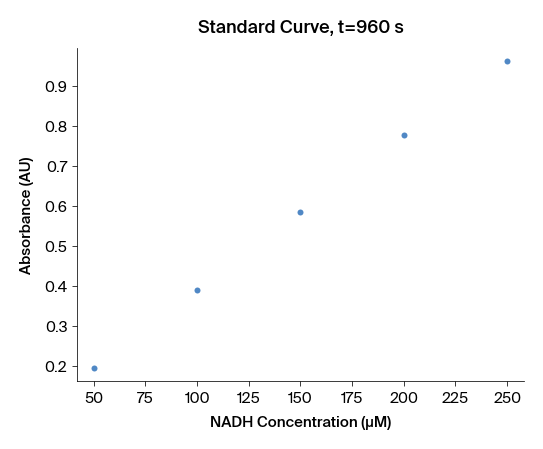

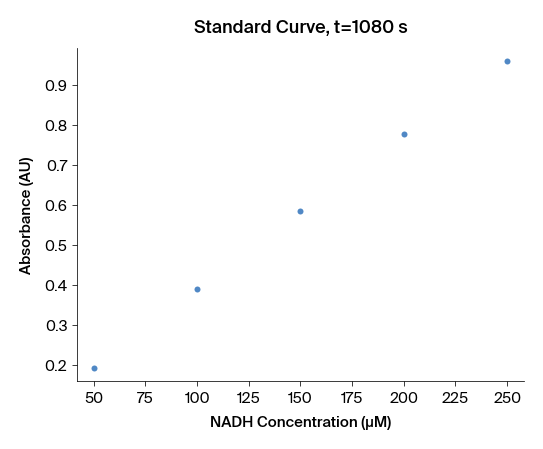

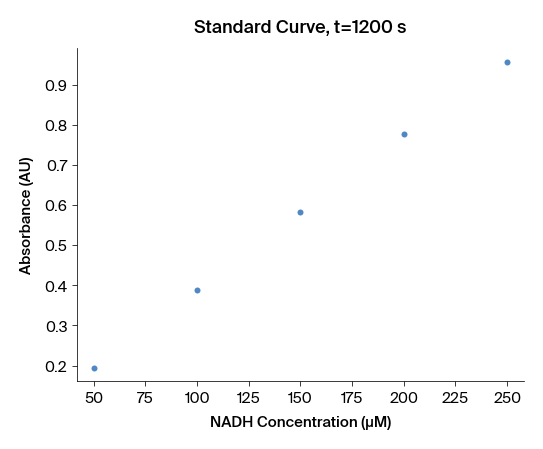

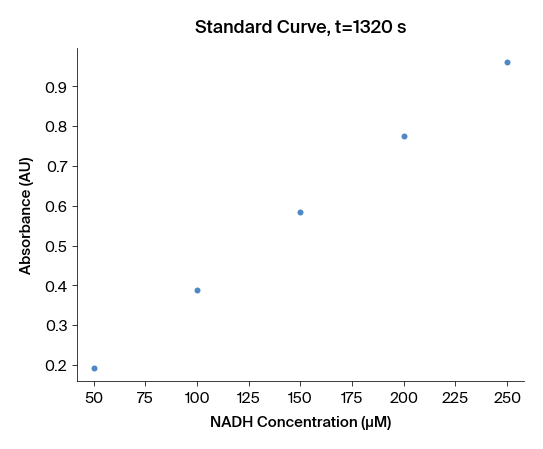

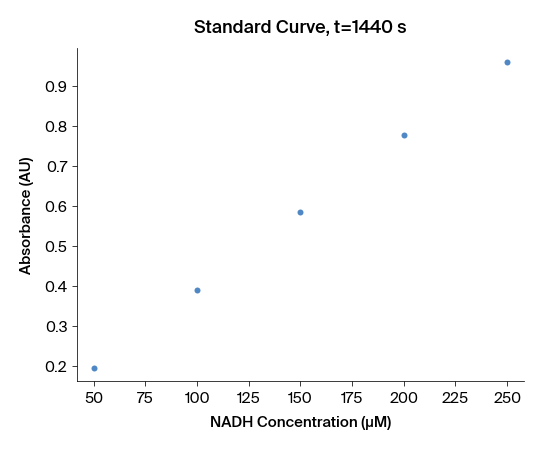

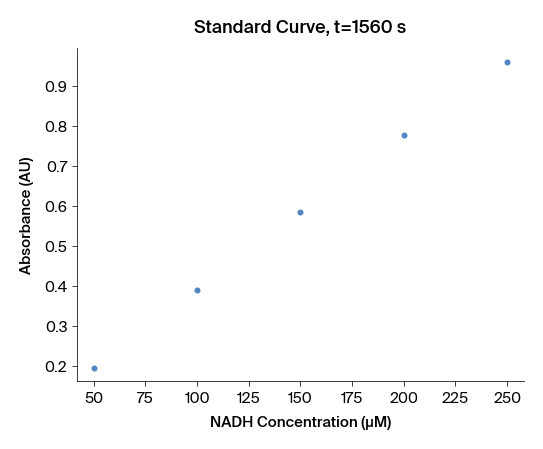

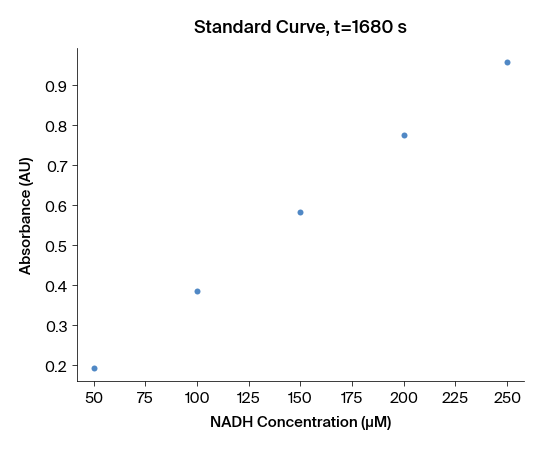

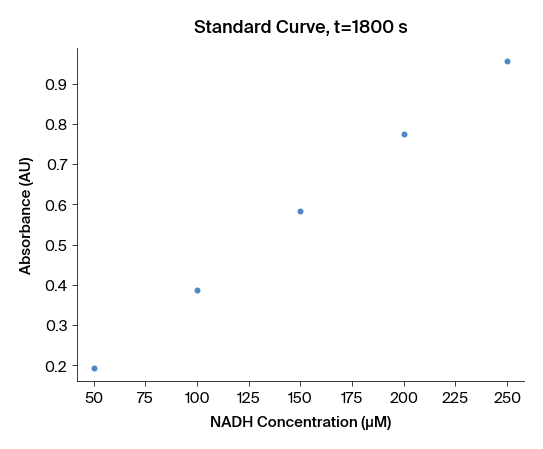

In [11]:
# Plot standard curves at each time point, which will be the basis for
# standard curve fitting and determining NADH concentrations in each well.

standards_output_dir = output_path + "/standard_curve_plots"
os.makedirs(standards_output_dir, exist_ok=True)

time_points = sample_data_collapsed["Cycle (seconds)"].unique()

for time_point in time_points:
    time_point_data = sample_data_collapsed[sample_data_collapsed["Cycle (seconds)"] == time_point]

    means = time_point_data[standard_columns].mean()
    std_devs = time_point_data[standard_columns].std()

    x_values = [int(col) for col in standard_columns]
    y_values = means.values
    y_errors = std_devs.values

    apc.mpl.setup()
    plt.figure(figsize=(8, 6))
    plt.errorbar(
        x_values,
        y_values,
        yerr=y_errors,
        fmt="o",
        capsize=5,
        label=f"Time Point {time_point}",
    )

    # User can update labels and title as needed.
    plt.xlabel("NADH Concentration (µM)")
    plt.ylabel("Absorbance (AU)")
    plt.title(f"Standard Curve, t={round(time_point)} s")

    file_path = os.path.join(
        standards_output_dir, f"standard_curve_timepoint_{round(time_point)}.png"
    )
    plt.savefig(file_path, transparent=False)

    plt.show()

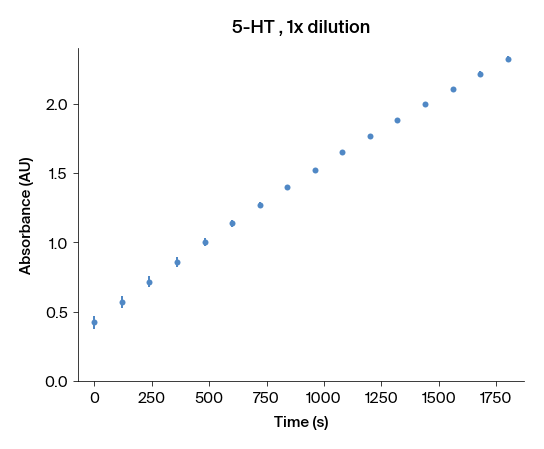

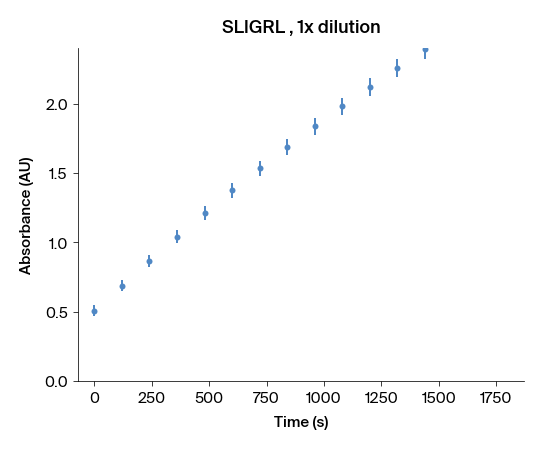

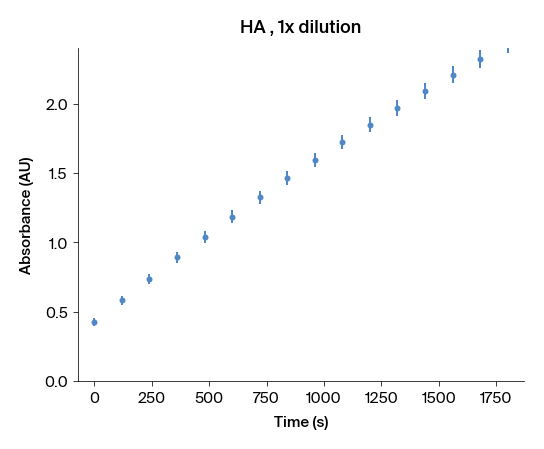

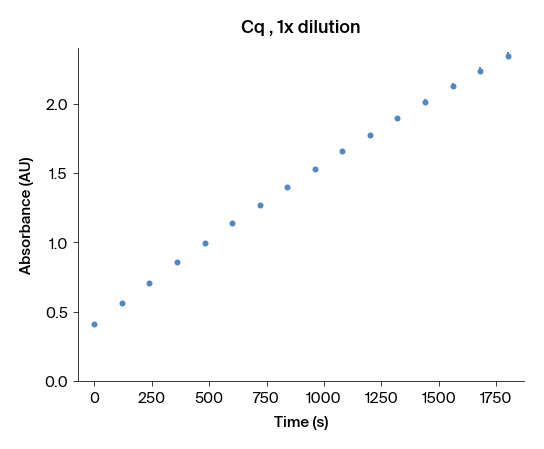

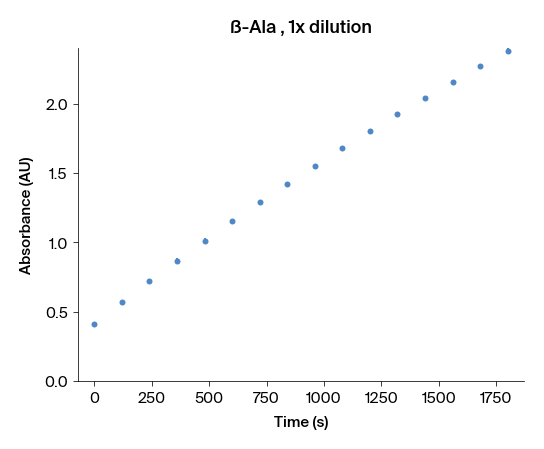

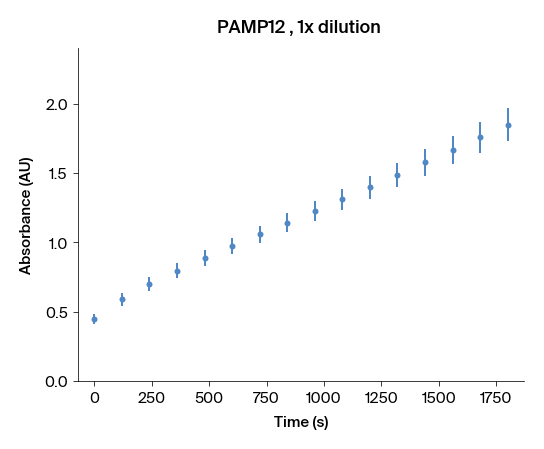

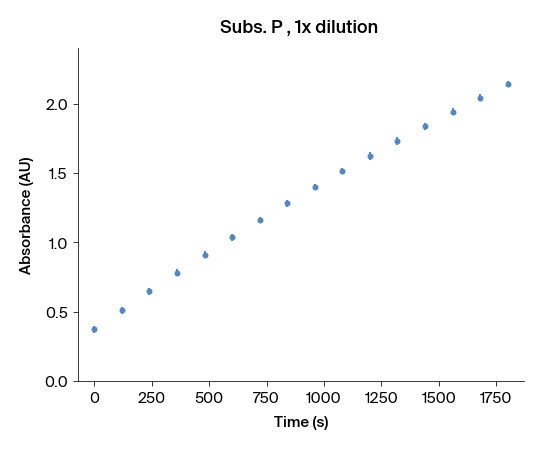

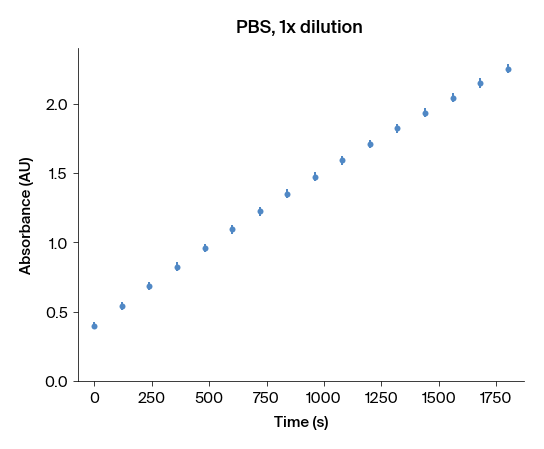

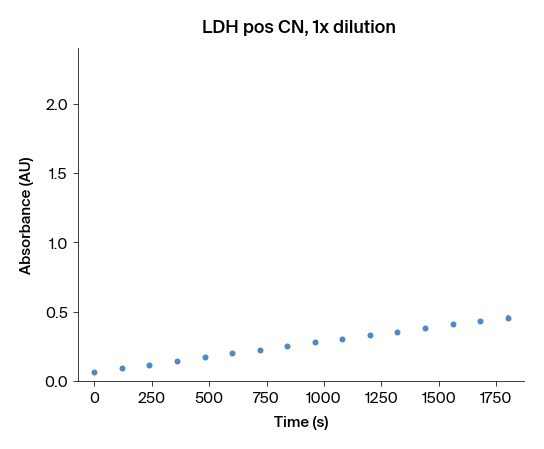

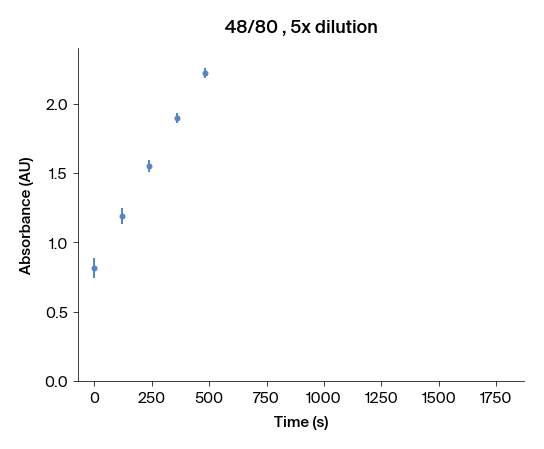

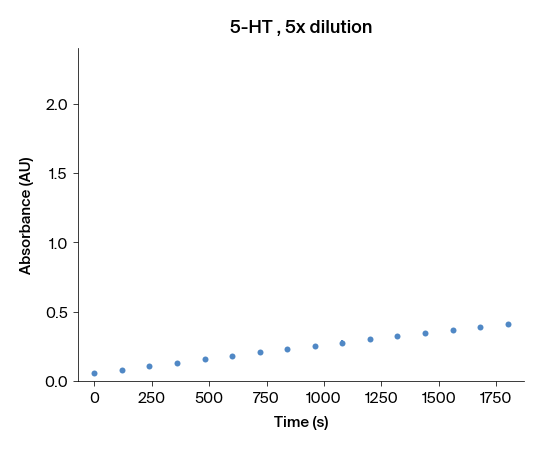

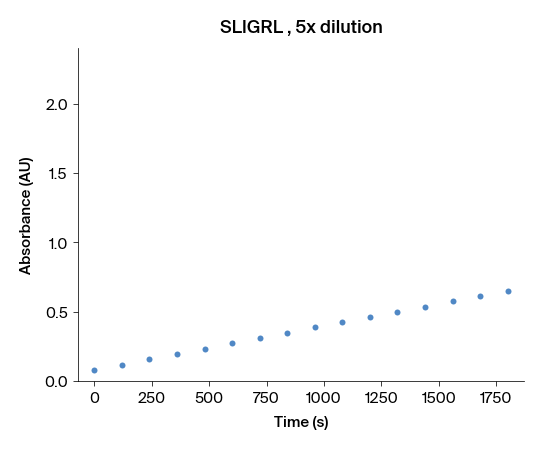

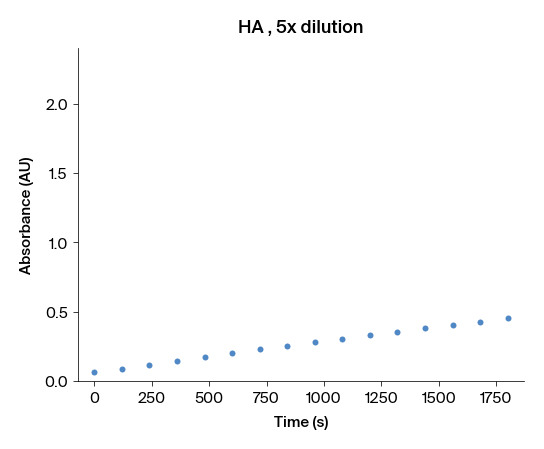

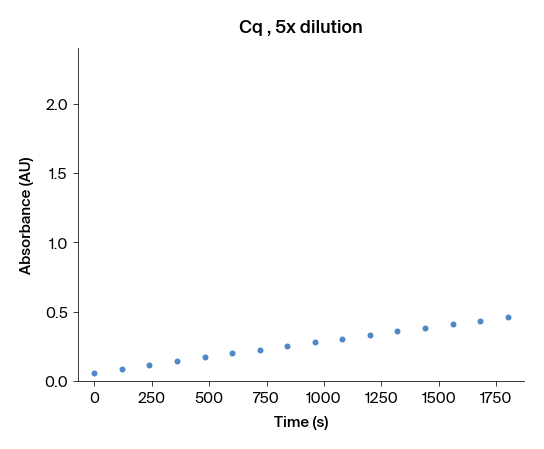

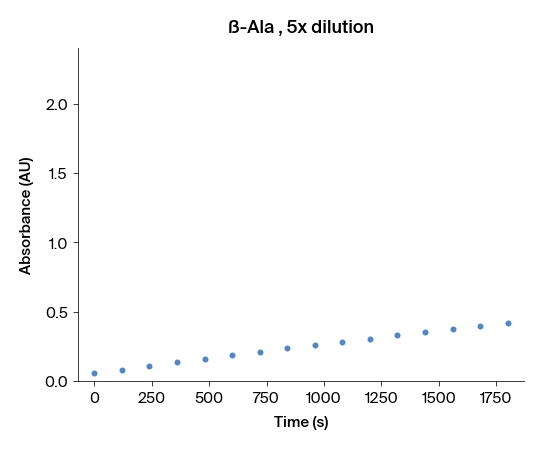

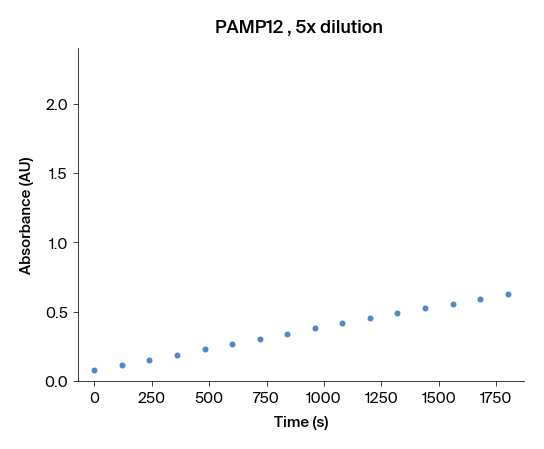

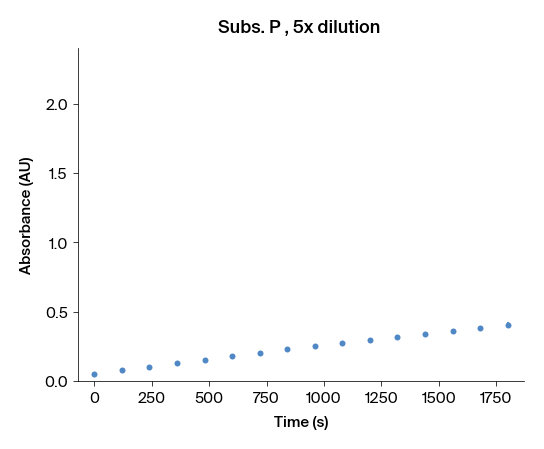

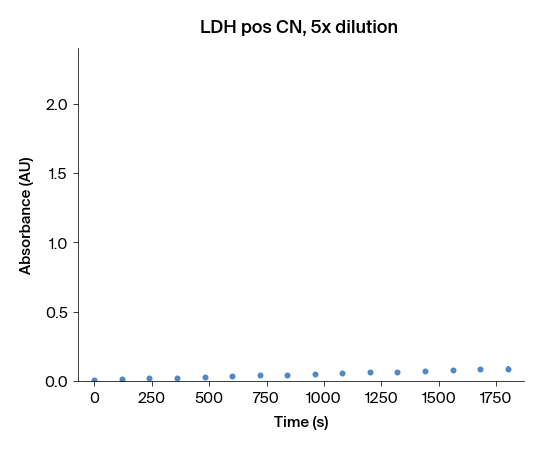

In [12]:
# Plot activity (signal vs. time) curves for each sample.
# Activity curves are used to select time points for enzyme activity quantification.

time_column = sample_data_collapsed.columns[0]
sample_columns = [
    col
    for col in sample_data_collapsed.columns
    if col not in standard_columns and col != time_column
]

samples_output_dir = output_path + "/activity_plots"
os.makedirs(samples_output_dir, exist_ok=True)


def sanitize_filename(text):
    """
    Convert a string of text into a valid file name by replacing
    or removing problematic ' ', '/', and ',' characters.

    Args:
        text: A string, such as a sample name, to be sanitized.

    Returns:
        str: The sanitized string, which can serve as a filename.
    """
    sanitized = text.replace(" ", "_").replace("/", "_").replace(",", "")
    return sanitized


for col in sample_columns:
    grouped = sample_data_collapsed.groupby(time_column)[col]
    means = grouped.mean()
    std_devs = grouped.std()

    x_values = means.index
    y_values = means.values
    y_errors = std_devs.values

    apc.mpl.setup()
    plt.figure(figsize=(8, 6))
    plt.errorbar(x_values, y_values, yerr=y_errors, fmt="o", capsize=5, label=col)

    # User can update labels and title as needed.
    plt.xlabel("Time (s)")
    plt.ylabel("Absorbance (AU)")
    plt.ylim(0, 2.4)
    plt.title(f"{col}")

    col_sanitized = sanitize_filename(col)
    file_path = os.path.join(samples_output_dir, f"activity_curve_{col_sanitized}.png")
    plt.savefig(file_path, transparent=False)

    plt.show()

In [13]:
# User must select time points t1 and t2 for analysis.
# Choose time points that fall in the linear range of the activity curves where possible.
t1 = 0  # s
t2 = 480  # s

if t1 is None or t2 is None:
    raise SystemExit("Please select time points for NADH and LDH quantification analysis")

In [14]:
# Curve fit will be performed on mean values of technical replicates,
# so a new dataframe containing the mean values will be generated.


def generate_mean_dataframe(collapsed_df, time_column):
    """
    Generate a mean dataframe with mean values for technical replicates at each time point.

    Args:
        collapsed_df: Dataframe containing labeled data with technical replicates.
        mean_df:
            A new dataframe with the same headers as collapsed_df,
            to be populated with mean values of technical replicates
        time_column: The name of the time column (i.e. 'Cycle (seconds)').

    Returns:
        pd.Dataframe:
            A populated dataframe containing the mean absorbance value
            for each sample at each time point.
    """
    mean_df = pd.DataFrame(columns=list(collapsed_df.columns))
    time_points = collapsed_df[time_column].unique()
    mean_df[time_column] = time_points

    for col in [c for c in collapsed_df.columns if c != time_column]:
        means = []

        for time_point in time_points:
            values = collapsed_df[collapsed_df[time_column] == time_point][col].dropna()
            mean_value = values.mean()
            means.append(mean_value)

        mean_df[col] = means

    return mean_df


sample_data_means = generate_mean_dataframe(sample_data_collapsed, time_column)
sample_data_means

,Cycle (seconds),"5-HT , 1x dilution","SLIGRL , 1x dilution","HA , 1x dilution","Cq , 1x dilution","ß-Ala , 1x dilution","PAMP12 , 1x dilution","Subs. P , 1x dilution","PBS, 1x dilution","LDH pos CN, 1x dilution",...,"Cq , 5x dilution","ß-Ala , 5x dilution","PAMP12 , 5x dilution","Subs. P , 5x dilution","LDH pos CN, 5x dilution",250,200,150,100,50
0,-0.0500,0.423667,0.508000,0.426333,0.412333,0.413667,0.449333,0.373333,0.397667,0.065667,...,0.059000,0.056000,0.077667,0.054000,0.009667,0.9710,0.7895,0.5930,0.3950,0.1980
1,118.9900,0.569000,0.687333,0.582667,0.562000,0.568000,0.591000,0.510333,0.541000,0.091667,...,0.088000,0.082667,0.113333,0.079000,0.014667,0.9725,0.7860,0.5910,0.3945,0.1970
2,239.1595,0.715500,0.865833,0.738833,0.710500,0.719833,0.698167,0.646167,0.683833,0.118500,...,0.116167,0.109167,0.151167,0.104500,0.019167,0.9665,0.7830,0.5895,0.3930,0.1960
3,360.0695,0.860833,1.041833,0.891833,0.856500,0.868833,0.795833,0.780167,0.824833,0.144833,...,0.144500,0.135500,0.190500,0.129500,0.024833,0.9660,0.7830,0.5880,0.3925,0.1955
4,479.9995,1.001167,1.211500,1.040833,0.998500,1.012833,0.886833,0.910167,0.960833,0.172167,...,0.172500,0.161167,0.229833,0.154500,0.030167,0.9665,0.7815,0.5875,0.3920,0.1945
5,599.8895,1.137500,1.375500,1.185500,1.136833,1.153500,0.974167,1.037167,1.094500,0.199167,...,0.199833,0.186500,0.267167,0.179167,0.035500,0.9645,0.7815,0.5875,0.3920,0.1945
6,719.9495,1.270500,1.534500,1.325500,1.271500,1.290500,1.059500,1.161500,1.224500,0.225500,...,0.227167,0.211500,0.304833,0.203500,0.041167,0.9640,0.7800,0.5860,0.3910,0.1945
7,840.0095,1.400167,1.688167,1.462167,1.403167,1.424500,1.141833,1.281833,1.350833,0.252500,...,0.253833,0.236167,0.342500,0.227500,0.046833,0.9630,0.7800,0.5860,0.3910,0.1945
8,959.9185,1.525167,1.836833,1.593500,1.530167,1.553500,1.225167,1.398833,1.473833,0.278167,...,0.279833,0.259167,0.378833,0.250167,0.051167,0.9615,0.7780,0.5845,0.3895,0.1935
9,1080.0590,1.648667,1.982333,1.724333,1.656000,1.681000,1.310000,1.514667,1.594000,0.305000,...,0.306333,0.283667,0.416000,0.273667,0.057333,0.9610,0.7780,0.5850,0.3895,0.1935


In [15]:
# This assay measures absorbance caused by NADH, a product of the LDH enzyme,
# so NADH concentrations at two time points are determined.
# Standard curve fits are determined at each of these time points.

time_column_list = sample_data_means[time_column].tolist()
time_column_list = [round(x) for x in time_column_list]

if t1 not in time_column_list or t2 not in time_column_list:
    raise SystemExit(
        "Time points not found. Please choose time points that are present in the dataset."
    )

else:
    t1loc = time_column_list.index(t1)
    t2loc = time_column_list.index(t2)

    row_t1 = sample_data_means.iloc[t1loc]
    row_t2 = sample_data_means.iloc[t2loc]

    if row_t1.isna().any() or row_t2.isna().any():
        print(
            """
            Time points successfully indexed for standard fitting.
            Warning: Data not available for all samples at these time points.
            """
        )
    else:
        print("Time points successfully indexed for standard fitting.")

Time points successfully indexed for standard fitting.


In [16]:
# Fit standard curve, t1

standard_ints = [int(x) for x in standard_columns]
x_values = np.array(standard_ints)
y_values_t1 = np.array([])

for col in standard_columns:
    value = sample_data_means.loc[t1loc, col]
    y_values_t1 = np.append(y_values_t1, value)


# Quadratic fit usually works best for absorbance data
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c


quadratic_params_t1, _ = curve_fit(quadratic_model, x_values, y_values_t1)
quadratic_predictions_t1 = quadratic_model(x_values, *quadratic_params_t1)
quadratic_r2_t1 = r2_score(y_values_t1, quadratic_predictions_t1)

print("t1 fit successful")
print(f"a, b, c: {quadratic_params_t1}")
print(f"R^2: {quadratic_r2_t1:.4f}")

t1 fit successful
a, b, c: [-9.28571443e-07  4.15957144e-03 -9.10000109e-03]
R^2: 0.9999


In [17]:
# Fit standard curve, t2

x_values = np.array(standard_ints)
y_values_t2 = np.array([])

for col in standard_columns:
    value = sample_data_means.loc[t2loc, col]
    y_values_t2 = np.append(y_values_t2, value)

quadratic_params_t2, _ = curve_fit(quadratic_model, x_values, y_values_t2)
quadratic_predictions_t2 = quadratic_model(x_values, *quadratic_params_t2)
quadratic_r2_t2 = r2_score(y_values_t2, quadratic_predictions_t2)

print("t2 fit successful")
print(f"a, b, c: {quadratic_params_t2}")
print(f"R^2: {quadratic_r2_t2:.4f}")

t2 fit successful
a, b, c: [-7.57142969e-07  4.09414289e-03 -8.90000210e-03]
R^2: 1.0000


In [18]:
# To streamline the output data, NADH and LDH concentrations are calculated in a new dataframe.
# Relevant absorbance data will be extracted from sample_data_collapsed,
# then transformed to NADH concentrations using standard fit,
# then used to calculate LDH concentration in activity units.


def extract_data_by_time(df, time_value, time_column):
    """
    Extract data for a given time point and create a dictionary of absorbance readings
    for each sample at the given time point.

    Args:
        df: Dataframe containing labeled data with technical replicates.
        time_value: The time point for which the dictionary should be generated.
        time_column (str):
            The name of the column containing time values. Typically 'Cycle (seconds)'.

    Returns:
        dict:
            A dictionary where keys are sample names (as strings) and values are lists of
            absorbance readings (as floats).
    """
    filtered_df = df[round(df[time_column]) == time_value]
    data_dict = {col: filtered_df[col].dropna().tolist() for col in sample_columns}

    return data_dict


def populate_dataframe_with_dict(df, data_dict, key_column, value_column):
    """
    Populate the results dataframe with absorbance values at a given time point.

    Args:
        df: The results dataframe to populate.
        data_dict:
            A dictionary with sample names as keys and lists of
            absorbance values as values.
        key_column:
            The string header of the column in df that will contain sample names.
        value_column:
            The string header of the column in df that will contain
            absorbance values at the relevant time point.

    Returns:
        pd.DataFrame:
            The populated dataframe relating sample names to their
            absorbance values at the relevant time point.
    """
    for sample_name, values in data_dict.items():
        for value in values:
            mask = (df[key_column] == sample_name) & (df[value_column].isna())
            if mask.any():
                df.loc[mask.idxmax(), value_column] = value
            else:
                new_row = {key_column: sample_name, value_column: value}
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df


t1_dict = extract_data_by_time(sample_data_collapsed, t1, time_column)
t2_dict = extract_data_by_time(sample_data_collapsed, t2, time_column)

sample_column = "Sample"
t1_abs_column = "Abs, t = " + str(t1)
t2_abs_column = "Abs, t = " + str(t2)
conc_columns = [sample_column, t1_abs_column, t2_abs_column]
NADH_LDH_concs = pd.DataFrame(columns=conc_columns)

NADH_LDH_concs = populate_dataframe_with_dict(NADH_LDH_concs, t1_dict, sample_column, t1_abs_column)
NADH_LDH_concs = populate_dataframe_with_dict(NADH_LDH_concs, t2_dict, sample_column, t2_abs_column)
NADH_LDH_concs

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_40782/3998069560.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


,Sample,"Abs, t = 0","Abs, t = 480"
0,"5-HT , 1x dilution",0.478,1.0355
1,"5-HT , 1x dilution",0.403,0.9915
2,"5-HT , 1x dilution",0.390,0.9765
3,"SLIGRL , 1x dilution",0.549,1.2645
4,"SLIGRL , 1x dilution",0.503,1.2005
5,"SLIGRL , 1x dilution",0.472,1.1695
6,"HA , 1x dilution",0.460,1.0895
7,"HA , 1x dilution",0.408,1.0035
8,"HA , 1x dilution",0.411,1.0295
9,"Cq , 1x dilution",0.427,0.9995


In [19]:
# The curve fit parameters can be used to calculate the NADH concentrations
# at different time points, which can be used to determine enzyme activity.


def calculate_NADH_from_Abs(quadratic_params, df, abs_column):
    """
    Uses NADH standard curve fits to calculate NADH levels from measured absorbance data.

    Args:
        quadratic_params:
            A list of quadratic parameters [a, b, c].
        df:
            A dataframe containing measured absorbance values.
        abs_column:
            The name of the dataframe column containing measured
            absorbance values.

    Returns:
        list[float]: Calculated NADH values.

    """
    a, b, c = quadratic_params  # y = ax^2 + bx + c
    x_values = []
    y_values = df[abs_column]

    for y in y_values:
        adjusted_c = c - y

        discriminant = b**2 - 4 * a * adjusted_c

        if discriminant >= 0:
            root1 = (-b + np.sqrt(discriminant)) / (2 * a)
            root2 = (-b - np.sqrt(discriminant)) / (2 * a)

            # The correct NADH concentration should fall within the part of the curve
            # where absorbance increases with increasing NADH concentration.
            # For concave up fit, choose the non-negative (greater) root.
            # For concave down fit, choose the lesser positive root.
            if a > 0:
                root = max(root1, root2)
                x_values.append(root)
            else:
                root = min(root1, root2)
                x_values.append(root)

        else:
            # Handle cases where the discriminant is negative.
            x_values.append(np.nan)

    x_values = np.array(x_values)
    return x_values


NADH_concs_t1 = calculate_NADH_from_Abs(quadratic_params_t1, NADH_LDH_concs, t1_abs_column)
NADH_concs_t2 = calculate_NADH_from_Abs(quadratic_params_t2, NADH_LDH_concs, t2_abs_column)

t1_NADH_column = "NADH, t = " + str(t1)
t2_NADH_column = "NADH, t = " + str(t2)

NADH_LDH_concs[t1_NADH_column] = NADH_concs_t1
NADH_LDH_concs[t2_NADH_column] = NADH_concs_t2
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480"
0,"5-HT , 1x dilution",0.478,1.0355,120.336057,268.420484
1,"5-HT , 1x dilution",0.403,0.9915,101.366508,256.517943
2,"5-HT , 1x dilution",0.390,0.9765,98.095538,252.473468
3,"SLIGRL , 1x dilution",0.549,1.2645,138.451683,331.331800
4,"SLIGRL , 1x dilution",0.503,1.2005,126.697084,313.582866
5,"SLIGRL , 1x dilution",0.472,1.1695,118.812250,305.032940
6,"HA , 1x dilution",0.460,1.0895,115.767915,283.108139
7,"HA , 1x dilution",0.408,1.0035,102.625906,259.758341
8,"HA , 1x dilution",0.411,1.0295,103.381901,266.793987
9,"Cq , 1x dilution",0.427,0.9995,107.418403,258.677731


In [20]:
# Assay samples are sometimes diluted so that absorbance
# falls within range for accurate measurement.
# Extraction of dilution factors is necessary to calculate LDH enzyme concentrations.
# Sample names typically include the treatment (i.e. 5HT 3 µM)
# followed by the dilution factor (i.e. 1x dilution).
# A regular expression is used to identify this dilution factor.


def extract_dilution_factor(sample_name):
    """
    Extracts the dilution factor from a sample name string.

    Args:
        sample_name: The sample name to parse, as a string.

    Returns:
        int:
            The extracted dilution factor,
            or 1 if no dilution factor is found.
    """
    match = re.search(r"(\d+)x dilution", sample_name)
    if match:
        return int(match.group(1))
    else:
        return 1


dilution_factors = [extract_dilution_factor(sample) for sample in NADH_LDH_concs[sample_column]]
NADH_LDH_concs["dilution"] = dilution_factors
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480",dilution
0,"5-HT , 1x dilution",0.478,1.0355,120.336057,268.420484,1
1,"5-HT , 1x dilution",0.403,0.9915,101.366508,256.517943,1
2,"5-HT , 1x dilution",0.390,0.9765,98.095538,252.473468,1
3,"SLIGRL , 1x dilution",0.549,1.2645,138.451683,331.331800,1
4,"SLIGRL , 1x dilution",0.503,1.2005,126.697084,313.582866,1
5,"SLIGRL , 1x dilution",0.472,1.1695,118.812250,305.032940,1
6,"HA , 1x dilution",0.460,1.0895,115.767915,283.108139,1
7,"HA , 1x dilution",0.408,1.0035,102.625906,259.758341,1
8,"HA , 1x dilution",0.411,1.0295,103.381901,266.793987,1
9,"Cq , 1x dilution",0.427,0.9995,107.418403,258.677731,1


In [21]:
# The change in NADH concentration over a known time interval can be used
# to calculate the LDH concentration in activity units.
# The extracted dilution factors will be used to determine the LDH
# concentration in the original supernatant sample.


def calculate_LDH_concs(df, t, V):
    """
    Calculates the LDH concentration based on the change in
    NADH concentration over a given time interval.

    Args:
        df:
            Input dataframe containing NADH concentrations
            at two time points and a dilution factor.
        t:
            Time interval between the two time points, in minutes.
        V:
            The total sample volume, in mL.

    Returns:
        list[float]:
            A list of calculated LDH concentrations.
    """
    LDH_concs = []

    for _index, row in df.iterrows():
        value_t2 = row[t2_NADH_column]
        value_t1 = row[t1_NADH_column]

        B = value_t2 - value_t1
        D = row["dilution"]

        if pd.isna(value_t2) or pd.isna(value_t1):
            LDH_concs.append(np.nan)

        else:
            conc = (B * D) / (t * V)
            if conc >= 0:
                LDH_concs.append(conc)

            else:
                LDH_concs.append(0)

    return LDH_concs


t = (t2 - t1) / 60  # Time interval in minutes.

LDH_concs = calculate_LDH_concs(NADH_LDH_concs, t, V)
NADH_LDH_concs["LDH"] = LDH_concs
NADH_LDH_concs.to_csv(output_filename + "_ldh_concs.csv", index=False)
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480",dilution,LDH
0,"5-HT , 1x dilution",0.478,1.0355,120.336057,268.420484,1,370.211067
1,"5-HT , 1x dilution",0.403,0.9915,101.366508,256.517943,1,387.878588
2,"5-HT , 1x dilution",0.390,0.9765,98.095538,252.473468,1,385.944825
3,"SLIGRL , 1x dilution",0.549,1.2645,138.451683,331.331800,1,482.200293
4,"SLIGRL , 1x dilution",0.503,1.2005,126.697084,313.582866,1,467.214455
5,"SLIGRL , 1x dilution",0.472,1.1695,118.812250,305.032940,1,465.551724
6,"HA , 1x dilution",0.460,1.0895,115.767915,283.108139,1,418.350562
7,"HA , 1x dilution",0.408,1.0035,102.625906,259.758341,1,392.831089
8,"HA , 1x dilution",0.411,1.0295,103.381901,266.793987,1,408.530215
9,"Cq , 1x dilution",0.427,0.9995,107.418403,258.677731,1,378.148321


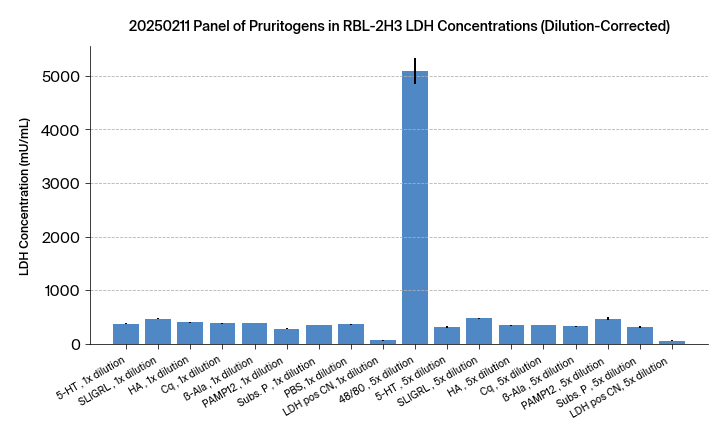

In [22]:
# Plot supernatant LDH concentrations for each sample.
# This plot visually represents the amount of cell death occurring
# in a given sample.
# Means and standard deviations of technical replicates are used to plot
# bars and error bars. Samples containing only NaN values are excluded.

grouped = (
    NADH_LDH_concs.groupby("Sample", sort=False)["LDH"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)
grouped = grouped[grouped["count"] > 0]

samples = grouped["Sample"]
ldh_mean = grouped["mean"]
ldh_std = grouped["std"]

apc.mpl.setup()
plt.figure(figsize=(10, 6))
plt.bar(samples, ldh_mean, yerr=ldh_std)

# User can update labels and title as needed.
plt.ylabel("LDH Concentration (mU/mL)", fontsize=12)
plt.title(experiment_id + " LDH Concentrations (Dilution-Corrected)", fontsize=14)

plt.xticks(rotation=30, ha="right", fontsize=10)

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=1.0)
plt.savefig(
    output_filename + "_LDH_concentrations.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)
plt.show()

In [23]:
# For samples with high LDH concentration, NADH readings may be off-scale.
# For samples where multiple dilutions have been analyzed, the sample with
# NADH readings within range (or closest to it) of the standard curve
# (0 - 250 µM) will be extracted and plotted.

samples_in_range = []
sample_names_found = set()

# Identify samples that are on scale.
for _, row in NADH_LDH_concs.iterrows():
    if row.iloc[4] <= 250:
        sample_with_dilution = row.iloc[0]
        sample_name = sample_with_dilution.split(",")[0]

        if sample_with_dilution not in samples_in_range:
            samples_in_range.append(sample_with_dilution)
            sample_names_found.add(sample_name)

# Ensure all sample names are represented.
for _, row in NADH_LDH_concs.iterrows():
    sample_with_dilution = row.iloc[0]
    sample_name, dilution = (
        sample_with_dilution.split(",")[0],
        sample_with_dilution.split(",")[-1],
    )

    if sample_name not in sample_names_found and "5x dilution" in dilution:
        samples_in_range.append(sample_with_dilution)
        sample_names_found.add(sample_name)

for _, row in NADH_LDH_concs.iterrows():
    sample_with_dilution = row.iloc[0]
    sample_name, dilution = (
        sample_with_dilution.split(",")[0],
        sample_with_dilution.split(",")[-1],
    )

    if sample_name not in sample_names_found and "1x dilution" in dilution:
        samples_in_range.append(sample_with_dilution)
        sample_names_found.add(sample_name)

# Keep 1x dilution if both dilutions are in range.
samples_dict = defaultdict(list)

for sample in samples_in_range:
    sample_name, dilution = sample.rsplit(", ", 1)
    samples_dict[sample_name].append(sample)

samples_in_range_filtered = []

for _sample_name, entries in samples_dict.items():
    if len(entries) > 1:
        preferred_sample = next((s for s in entries if "1x dilution" in s), entries[0])
    else:
        preferred_sample = entries[0]

    samples_in_range_filtered.append(preferred_sample)

samples_in_range_filtered_ordered = []
seen_sample_names = set()

# Restore original order of entries.
for _, row in NADH_LDH_concs.iterrows():
    sample_with_dilution = row.iloc[0]
    sample_name = sample_with_dilution.split(",")[0]

    for full_sample in samples_in_range_filtered:
        if sample_name in full_sample and full_sample not in seen_sample_names:
            samples_in_range_filtered_ordered.append(full_sample)
            seen_sample_names.add(full_sample)
            break

samples_in_range_filtered = samples_in_range_filtered_ordered

NADH_LDH_concs_in_range = NADH_LDH_concs[
    NADH_LDH_concs["Sample"].isin(samples_in_range_filtered)
].copy()
NADH_LDH_concs_in_range["Sample"] = NADH_LDH_concs_in_range["Sample"].apply(
    lambda x: x.split(",")[0] if "," in x else x
)

NADH_LDH_concs_in_range["Sample"] = pd.Categorical(
    NADH_LDH_concs_in_range["Sample"],
    categories=[s.split(",")[0] for s in samples_in_range_filtered],
    ordered=True,
)

NADH_LDH_concs_in_range = NADH_LDH_concs_in_range.sort_values(by="Sample").reset_index(drop=True)
NADH_LDH_concs_in_range.to_csv(output_filename + "_LDH_concs_filtered.csv", index=False)
NADH_LDH_concs_in_range

,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480",dilution,LDH
0,5-HT,0.048,0.1475,13.769703,38.474671,5,308.812103
1,5-HT,0.053,0.1535,14.979514,39.961750,5,312.277949
2,5-HT,0.063,0.1695,17.401113,43.931359,5,331.628078
3,SLIGRL,0.072,0.2275,19.582810,58.371126,5,484.853955
4,SLIGRL,0.080,0.2335,21.523897,59.869396,5,479.318739
5,SLIGRL,0.088,0.2375,23.466685,60.868715,5,467.525379
6,HA,0.055,0.1685,15.463623,43.683085,5,352.743273
7,HA,0.061,0.1735,16.916582,44.924687,5,350.101316
8,HA,0.068,0.1775,18.612902,45.918387,5,341.318560
9,Cq,0.052,0.1655,14.737499,42.938402,5,352.511278


/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_40782/2396625024.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_long["Sample"] = samples_long["Sample"].str.strip()  # Removes leading/trailing spaces


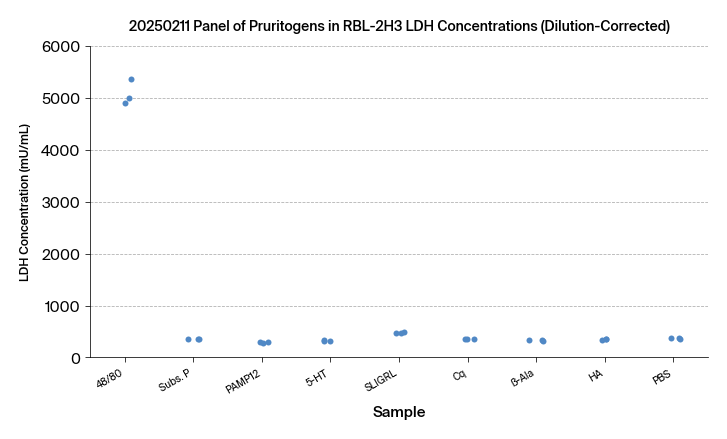

In [24]:
# Plot simplified graph.
"""
grouped = (
    NADH_LDH_concs_in_range.groupby("Sample", sort=False)["LDH"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)
grouped = grouped[grouped["count"] > 0]  # Keep only samples with replicates
"""
samples_long = NADH_LDH_concs_in_range[["Sample", "LDH"]]
samples_long["Sample"] = samples_long["Sample"].str.strip()  # Removes leading/trailing spaces

sample_order = ["48/80", "Subs. P", "PAMP12", "5-HT", "SLIGRL", "Cq", "ß-Ala", "HA", "PBS"]

plt.figure(figsize=(10, 6))

sns.stripplot(
    data=samples_long,
    x="Sample",
    y="LDH",
    jitter=True,
    size=6,
    # order=grouped["Sample"].tolist(), # Ensure sample order matches the grouped data
    order=sample_order
)

plt.ylabel("LDH Concentration (mU/mL)", fontsize=12)
plt.title(experiment_id + " LDH Concentrations (Dilution-Corrected)", fontsize=14)

plt.xticks(rotation=30, ha="right", fontsize=10)

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=1.0)

plt.ylim(0, 6000)

plt.savefig(
    output_filename + "_LDH_concentrations_in_range.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)

plt.show()

In [25]:
# One-way ANOVA is the most appropriate statistical test for this experiment.

LDH_concs = NADH_LDH_concs[["Sample", "LDH"]]
LDH_concs = LDH_concs.dropna(subset=["LDH"])
grouped_data = [group["LDH"].values for _, group in LDH_concs.groupby("Sample")]

anova_result = f_oneway(*grouped_data)
print(f"ANOVA result: F-value = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA result: F-value = 1138.4813031301476, p-value = 5.939452435702224e-44


In [26]:
# Tukey's HSD test is the most appropriate statistical test for post-hoc analysis.

tukey_result = pairwise_tukeyhsd(endog=LDH_concs["LDH"], groups=LDH_concs["Sample"], alpha=0.05)
print(tukey_result)

tukey_df = pd.DataFrame(
    data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0]
)
tukey_df.to_csv(output_filename + "_tukey_hsd_results.csv", index=False)

                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
         group1                   group2           meandiff  p-adj    lower      upper    reject
------------------------------------------------------------------------------------------------
     48/80 , 5x dilution       5-HT , 1x dilution -4713.0828    0.0  -4890.124 -4536.0416   True
     48/80 , 5x dilution       5-HT , 5x dilution -4776.8549    0.0 -4953.8961 -4599.8138   True
     48/80 , 5x dilution         Cq , 1x dilution -4707.7089    0.0   -4884.75 -4530.6677   True
     48/80 , 5x dilution         Cq , 5x dilution -4741.3765    0.0 -4918.4177 -4564.3354   True
     48/80 , 5x dilution         HA , 1x dilution  -4687.857    0.0 -4864.8982 -4510.8158   True
     48/80 , 5x dilution         HA , 5x dilution -4746.3732    0.0 -4923.4144 -4569.3321   True
     48/80 , 5x dilution LDH pos CN, 1x dilution  -5028.0615    0.0 -5205.1027 -4851.0204   True
     48/80 , 5x dilution LDH p

In [27]:
import sys

loaded_modules = {
    name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
}
print(loaded_modules)

{'re': '2.2.1', 'ipaddress': '1.0', 'ipykernel._version': '6.29.4', 'json': '2.0.9', 'jupyter_client._version': '8.6.2', 'platform': '1.0.8', 'zmq.sugar.version': '26.0.3', 'zmq.sugar': '26.0.3', 'zmq': '26.0.3', 'logging': '0.5.1.2', 'traitlets._version': '5.14.3', 'traitlets': '5.14.3', 'jupyter_core.version': '5.7.2', 'jupyter_core': '5.7.2', 'zlib': '1.0', '_curses': b'2.2', 'socketserver': '0.4', 'argparse': '1.1', 'dateutil._version': '2.9.0.post0', 'dateutil': '2.9.0.post0', 'six': '1.16.0', '_decimal': '1.70', 'decimal': '1.70', 'platformdirs.version': '4.2.2', 'platformdirs': '4.2.2', '_csv': '1.0', 'csv': '1.0', 'jupyter_client': '8.6.2', 'ipykernel': '6.29.4', 'IPython.core.release': '8.26.0', 'executing.version': '2.0.1', 'executing': '2.0.1', 'pure_eval.version': '0.2.2', 'pure_eval': '0.2.2', 'stack_data.version': '0.6.3', 'stack_data': '0.6.3', 'pygments': '2.18.0', 'decorator': '5.1.1', 'wcwidth': '0.2.13', 'prompt_toolkit': '3.0.47', 'parso': '0.8.4', 'jedi': '0.19.1',

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_40782/3849240522.py:4: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.__version__.
  name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
